### Introduction to Hierarchical Bayes

In this lecture we'll cover a basic intro to hierarchical Bayesian modelling (HBM)/hierarchical probabilistic inference. We'll cover the following:

1) What is HBM?
 - Where is it used/why is it useful?
 - Some examples
  - Stellar populations (The CMD/HRD).
  - Stellar ages.
  - Hubble flow.
  - Combining measurements, e.g RVs from separate orders, rotation periods from separate light curves.
  - Exoplanet populations/stellar flares/rotation periods.
 
2) Worked example: fitting a line to data.
 - With emcee.
 - With PyMC3.
 
3) Exercise:
 - Gyrochronology

# 1. What is HBM?

"Hierarchical Bayesian modelling is where you learn about an underlying population (or individual) using a group of individuals (or observations)". -- Angie Wolfgang.

Some types of hierarchical Bayesian models could also be described as a type of Bayesian inference where you infer the parameters of the model AND the parameters of the prior at the same time.

Most data analysis problems in astronomy can be written as a hierarchical problem, but often aren't. For example,  any time there is any 'data reduction' step, that step could be included hierarchically in the inference. However, it isn't always necessary to build a hierarchical model -- sometime it could add a lot of computation time to an otherwise trivial calculation. 

**Where is it used?**

*Examples.*

 - Stellar populations (The CMD/HRD).
 - Stellar ages.
 - Hubble flow.
 - Combining measurements, e.g RVs from separate orders, rotation periods from separate light curves.
 - Exoplanet populations/stellar flares/rotation periods.
 

**Why is it useful?**

HBM is often the more principled way to perform parameter estimation in astronomy, but there are some real situations where HBM is really the only way to solve a problem.

However, there are also some examples of problems that do not necessarily need to be hierarchical. Be pragmatic.

Cons: usually involves LOTS of parameters...

# 2. Example: fitting a line to data

Let's start with fitting a line to data, "The 'hello world' of astrostats" -- Dan Foreman-Mackey.

In general, whenever I start a new problem that requires an HBM, I proceed in three stages: PGM, model, sampling. I'll always draw a PGM to begin with, and write out the joint probability with its conditional factorization. Then I'll write down the maths -- the model, the priors, likelihood and the posterior. Finally I'll code it up and sample from the posterior.

*Exercise 1: Draw the PGM for a simple straight line model.*

*Exersize 2: write down the joint probability for this model and the factorization.*

How might this be a hierarchical problem?

1. Go up a level -- infer the prior at the same time.
2. Go down a level -- use a more raw version of the data.

*Exercise 3: write down the model and the likelihood function for the simple, non-hierarchical straight-line fit.*

*Exercise 4: repeat exercises 2 and 3 for the 1st hierarchical scenario*

The model (deterministic): 

$$y = a + bx$$

The priors (stochastic):

$$a \sim \mathcal{N}(\mu_a, \sigma_a)$$
$$b \sim \mathcal{N}(\mu_b, \sigma_b)$$

The likelihood function:

$$ \ln(\mathcal{L})\propto-\sum_{n=0}^N \frac{(y_\mathrm{obs} -  y_\mathrm{model})^2}{2\sigma_y^2}$$

What would the model and likelihood look like for the hierarchical versions?

The model (deterministic):

$$y = a + bx$$

The priors (stochastic):
$$a \sim \mathcal{N}(\mu_a, \sigma_a)$$
$$b \sim \mathcal{N}(\mu_b, \sigma_b)$$

The likelihood:
$$ \ln(\mathcal{L})\propto-\sum_{n=0}^N \frac{(y_\mathrm{obs} - y_\mathrm{model})^2}{2\sigma_y^2}$$

Why do these look the same?

Let's code this up. We'll start by simulating some data. First, let's draw values of a and b from the priors, using the hyperparameters.

In [256]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# M is the number of lines.
M = 25

# Draw 'a' values from a Gaussian with mean, mu_a, and standard deviation, sigma_a.
# This will be our prior when we do the inference. mu_a and sigma_a will be the hyperparameters.
true_mu_a = 1.02
true_sigma_a = .4
true_a = np.random.randn(M)*true_sigma_a + true_mu_a

# Similarly, draw 'b' values from a Gaussian with mean, mu_b, and standard deviation, sigma_b.
true_mu_b = .52
true_sigma_b = .08
true_b = np.random.randn(M)*true_sigma_b + true_mu_b

Let's plot these distributions

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


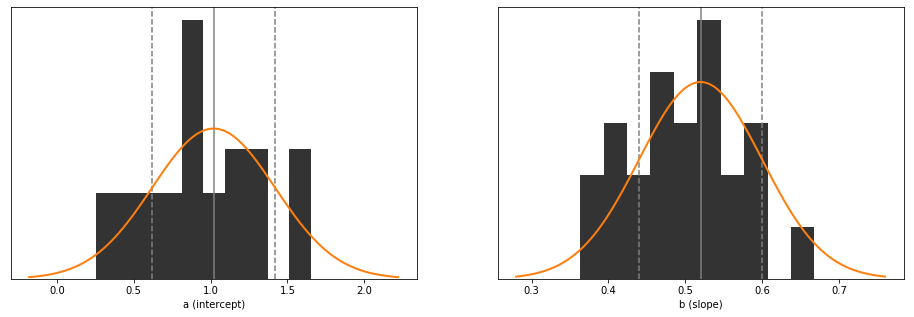

In [257]:
def Gaussian(x, mu, sigma):
    return 1./(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2/sigma**2/2)

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
ax.hist(true_a, normed=True, color=".2");
ax.set_xlabel("a (intercept)")
ax.axvline(true_mu_a, color=".5")
ax.axvline(true_mu_a - true_sigma_a, color=".5", ls="--")
ax.axvline(true_mu_a + true_sigma_a, color=".5", ls="--")

xa = np.linspace(true_mu_a - (3*true_sigma_a), true_mu_a + (3*true_sigma_a), 100)
plt.plot(xa, Gaussian(xa, true_mu_a, true_sigma_a), color="C1", lw=2)

ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(122)
ax.hist(true_b, normed=True, color=".2");
ax.set_xlabel("b (slope)")
ax.axvline(true_mu_b, color=".5")
ax.axvline(true_mu_b - true_sigma_b, color=".5", ls="--")
ax.axvline(true_mu_b + true_sigma_b, color=".5", ls="--")

xb = np.linspace(true_mu_b - (3*true_sigma_b), true_mu_b + (3*true_sigma_b), 100)
plt.plot(xb, Gaussian(xb, true_mu_b, true_sigma_b), color="C1", lw=2)

ax.axes.get_yaxis().set_visible(False)

Now simulate the observations

In [350]:
# N is the number of x-y observations.
N = 10

# y is observed with noise.
sigma_y = 5
yerr = np.tile(np.ones(N)*sigma_y, (M, 1))

np.random.seed(42)

x = np.tile(np.linspace(0, 9, N), (M, 1))
y = true_a[:, None] + true_b[:, None]*x + np.random.randn(M, N)*sigma_y

Plot the first line.

Text(0, 0.5, 'y')

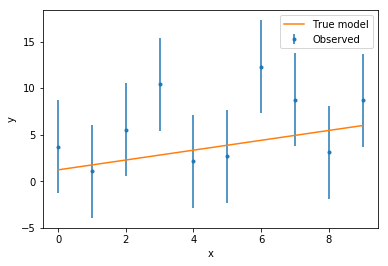

In [351]:
plt.errorbar(x[0, :], y[0, :], yerr=yerr[0, :], fmt=".", label="Observed")
plt.plot(x[0, :], true_a[0] + true_b[0]*x[0, :], label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Let's start by fitting a straight line to these data.

We'll define the model, prior, likelihood and posterior functions for a non-hierarchical straight-line fit, as we would if we were using emcee.

In [357]:
# The model (deterministic)
def model(a, b, x):
    return a + b*x

# The likelihood function
def lnlike(pars, x, y, yerr):
    a, b = pars
    ymodel = model(a, b, x)
    return -.5*np.sum((ymodel - y)**2/yerr**2)

# The prior function (stochastic/probabilistic)
def lnprior(pars):
    a, b = pars
    return -.5*(a - 1)**2/.8**2 -.5*(b - .6)**2/.1**2
    
# The posterior function
def lnprob(pars, x, y, yerr):
    return lnlike(pars, x, y, yerr) + lnprior(pars)

And let's run emcee on just a single straight line (although you never really need to use emcee to fit a straight line because there's an analytic solution).

In [365]:
import emcee
np.random.seed(42)

ndim, nwalkers, nsteps = 2, 100, 1000
p0 = [np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[x, y, yerr])
sampler.run_mcmc(p0, nsteps, progress=True);

burnin = 100
samples = np.reshape(sampler.chain[:, burnin:, :], (nwalkers*(nsteps - burnin), ndim))

100%|██████████| 1000/1000 [00:02<00:00, 466.22it/s]


Plot the posterior marginals.

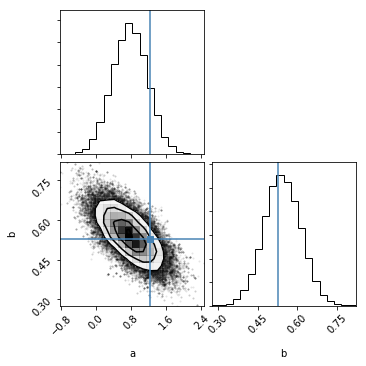

In [366]:
import corner

fig = corner.corner(samples, truths=[true_a[0], true_b[0]], labels=["a", "b"])

Let's plot the result on top of the true line.

Text(0, 0.5, 'y')

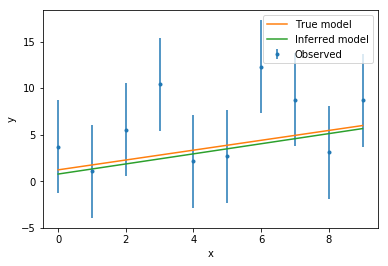

In [367]:
inf_a, inf_b = np.median(samples, axis=0)

plt.errorbar(x[0, :], y[0, :], yerr=yerr[0, :], fmt=".", label="Observed")
plt.plot(x[0, :], true_a[0] + true_b[0]*x[0, :], label="True model")
plt.plot(x[0, :], inf_a + inf_b*x[0, :], label="Inferred model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

In [369]:
aerr, berr = np.std(samples[:, 0]), np.std(samples[:, 1])
print("True a = {0:.2f}, Inferred = {1:.2f} +/- {2:.2f}".format(true_a[0], inf_a, aerr))
print("True b = {0:.2f}, Inferred = {1:.2f} +/- {2:.2f}".format(true_b[0], inf_b, aerr))

True a = 1.22, Inferred = 0.77 +/- 0.40
True b = 0.53, Inferred = 0.54 +/- 0.40


Those error bars are pretty large. Let's see if we can do better with a hierarchical version.

Plot all the lines on the same axes.

Text(0, 0.5, 'y')

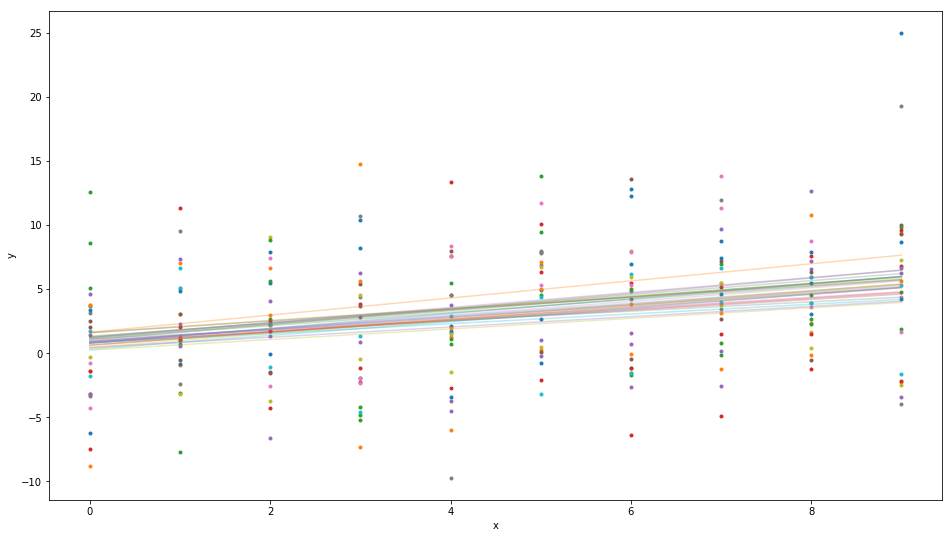

In [371]:
plt.figure(figsize=(16, 9))
plt.plot(x.T, y.T, ".")
plt.plot(true_a[None, :] + true_b[None, :]*x.T, alpha=.3)
plt.xlabel("x")
plt.ylabel("y")

*Question: How many free parameters will there be in the hierarchical model?*

The sampling method we choose will dictate how we write the code. We're going to start with sampling in emcee because it is more explicit and less symbolic. Later we'll code this up using PyMC3, a probabilistic programming package. You'll see how PyMC3, and probabilistic programming packages like it (e.g. STAN, BUGS, and many more) uses PGMs.

How would you do this using PyMC3?

In [ ]:
# Cell 8

import pymc3 as pm

simple_model = pm.Model()

with simple_model:
    
    # Priors over a and b
    a = pm.Normal('a', mu=1.02, sigma=.4)
    b = pm.Normal('b', mu=.52, sigma=.08)

    # The deterministic model
    mu = model(a, b, x[0, :])

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=yerr[0, :], observed=y[0, :])

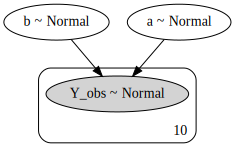

In [274]:
pm.model_to_graphviz(simple_model)

In [265]:
# Cell 9

with simple_model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4777.62draws/s]
The number of effective samples is smaller than 25% for some parameters.


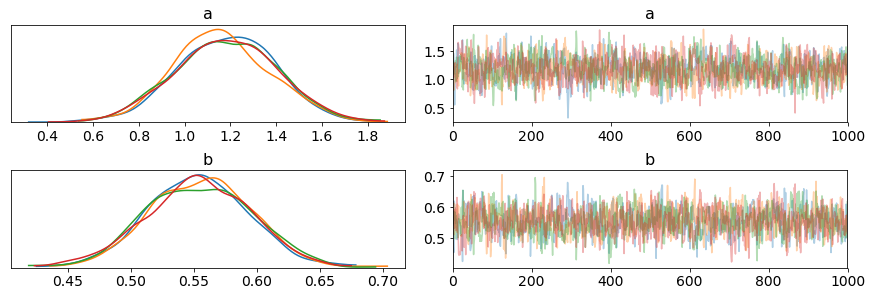

In [266]:
# Cell 10

ax = pm.traceplot(trace);

In [267]:
# Cell 11

pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.18,0.22,0.01,0.76,1.59,1074.09,1.0
b,0.55,0.04,0.00,0.48,0.64,966.04,1.0


Now let's try the hierarchical version.

*Exercise 5: discuss with a partner how you would code up the model, prior, likelihood and posterior functions. What changes in the hierarchical version?*

*Question: how many free parameters are there?*

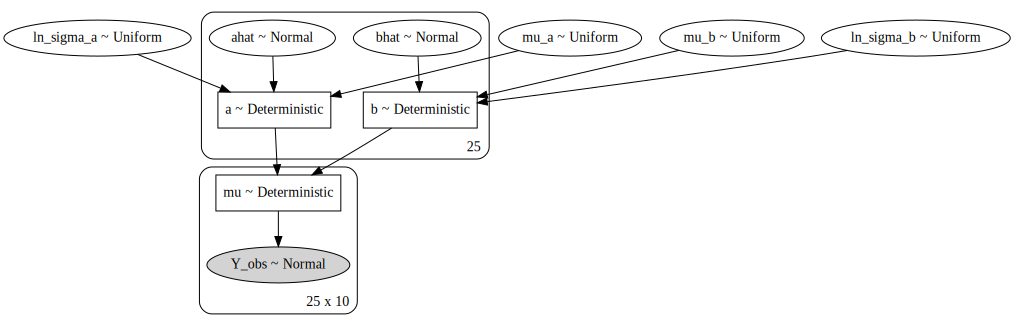

In [373]:
# Cell 12

hierarchical_model = pm.Model()

with hierarchical_model:
    
    # hyperpriors over mu_a, mu_b, sigma_a, and sigma_b
    mu_a = pm.Uniform('mu_a', lower=-10, upper=10)
    mu_b = pm.Uniform('mu_b', lower=-10, upper=10)
    ln_sigma_a = pm.Uniform('ln_sigma_a', lower=-3, upper=2)
    ln_sigma_b = pm.Uniform('ln_sigma_b', lower=-3, upper=2)
    
    # Priors over a and b -- now these are inferred.
    ahat = pm.Normal('ahat', mu=0, sigma=1, shape=M)
    a = pm.Deterministic("a", ahat*pm.math.exp(ln_sigma_a) + mu_a)
    bhat = pm.Normal('bhat', mu=0, sigma=1, shape=M)
    b = pm.Deterministic("b", bhat*pm.math.exp(ln_sigma_b) + mu_b)

    # The deterministic model
    mu = pm.Deterministic("mu", model(a[:, None], b[:, None], x))

    # Likelihood of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=yerr, observed=y)
    
pm.model_to_graphviz(hierarchical_model)

In [269]:
# Cell 13

with hierarchical_model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bhat, ahat, ln_sigma_b, ln_sigma_a, mu_b, mu_a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:12<00:00, 487.69draws/s]


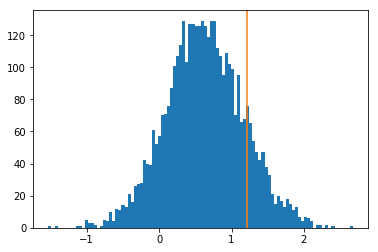

In [270]:
# Cell 14

i = 0
plt.hist(trace.ahat[:, i], 100);
plt.axvline(true_a[i], color="C1")

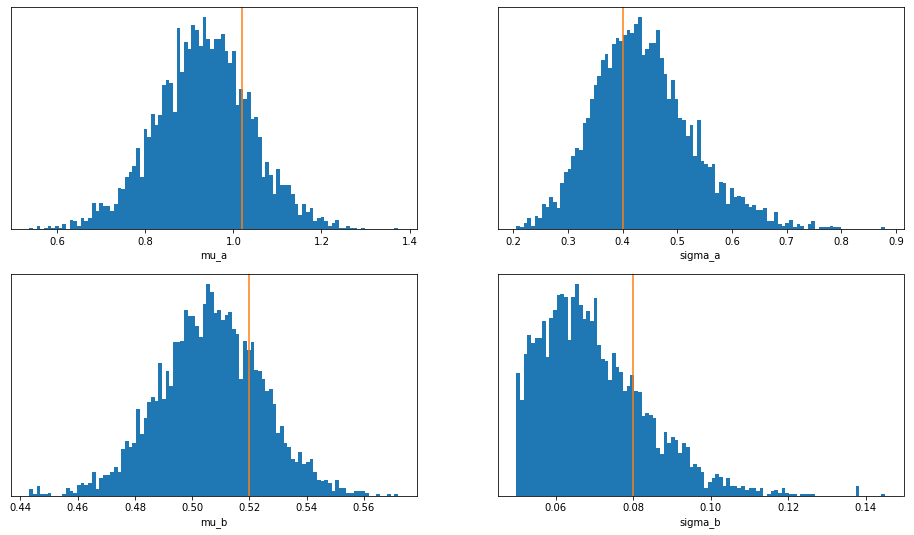

In [271]:
# Cell 15

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(221)
ax.hist(trace.mu_a, 100);
ax.axvline(true_mu_a, color="C1")
ax.set_xlabel("mu_a")
ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(222)
ax.hist(np.exp(trace.ln_sigma_a), 100);
ax.axvline(true_sigma_a, color="C1")
ax.set_xlabel("sigma_a")
ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(223)
ax.hist(trace.mu_b, 100);
ax.axvline(true_mu_b, color="C1")
ax.set_xlabel("mu_b")
ax.axes.get_yaxis().set_visible(False)

ax = fig.add_subplot(224)
ax.hist(np.exp(trace.ln_sigma_b), 100);
ax.axvline(true_sigma_b, color="C1")
ax.set_xlabel("sigma_b")
ax.axes.get_yaxis().set_visible(False)

*Exercise: try adjusting M and see how these results change.*

How would we code this up in emcee?

*Exercise: discuss with a partner -- how does the code in cell 5 change in the hierarchical version?*

In [273]:
# Cell 16

# The model is the same.

# The priors go into the likelihood function
def lnlike(pars, x, y, yerr):
    a = pars[:M]
    b = pars[M:M*2]
    mu_a, mu_b, log_sigma_a, log_sigma_b = pars[M*2:]
    sigma_a, sigma_b = np.exp(log_sigma_a), np.exp(log_sigma_b)
    
    # The model is the same
    ymodel = model(a[:, None], b[:, None], x)
    
    # The original likelihood function
    lnlikelihood = -.5*np.sum((ymodel - y)**2/yerr**2)
    
    # What used to be the lnprior goes here.
    lnprior = np.sum(-log_sigma_a -.5*(a - mu_a)**2/sigma_a**2 \
                     -log_sigma_b -.5*(b - mu_b)**2/sigma_b**2)
    
    # Return what used to be the posterior probability.
    return lnlikelihood + lnprior

# The prior function is now a hyper-prior function.
def lnhyperprior(pars):
    a = pars[:M]
    b = pars[M:M*2]
    mu_a, mu_b, log_sigma_a, log_sigma_b = pars[M*2:]
    
    # There is no longer a prior over a and b: the hyperprior is over mu_a, mu_b, sigma_a and sigma_b.
    # Let's use a uniform prior.
    if mu_a < -10 or mu_a > 10 or log_sigma_a < -3 or log_sigma_a > 2 or mu_b < -3 or mu_b > 2 \
        or log_sigma_b < -3 or log_sigma_b > 2:
        return -np.inf
    return 0.
    
# The posterior probability function
def lnprob(pars, x, y, yerr):
    return lnlike(pars, x, y, yerr) + lnhyperprior(pars)

Let's test this likelihood function.

*Question: how many free parameters are there?*

In [222]:
# Cell 17

ndim = M*2 + 4
pars_init = np.zeros(ndim)

# We are starting the MCMC at the true values
pars_init[:M] = true_a
pars_init[M:M*2] = true_b
pars_init[M*2:] = true_mu_a, true_mu_b, np.log(true_sigma_a), np.log(true_sigma_b)

# Always check that the lnlike is finite and that 'bad' parameters give a worse lnlike
print(lnlike(pars_init, x, y, yerr))
print(lnlike(pars_init+.1, x, y, yerr))
print(lnlike(pars_init-.1, x, y, yerr))

-7.857058744863391
-67.16299404558353
-25.685816666024003


Run the sampler.

In [223]:
# Cell 18

p0 = [pars_init+np.random.randn(ndim)*1e-4 for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[x, y, yerr])
sampler.run_mcmc(p0, 2000, progress=True);

100%|██████████| 2000/2000 [00:08<00:00, 239.21it/s]


In [224]:
# Cell 19

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
print("true = ", pars_init)
print("inferred = ", np.median(samples, axis=0))

true =  [ 1.21868566  0.96469428  1.27907542  1.62921194  0.92633865  0.50126904
  0.64633703  0.58139478  0.48244205  0.5634048   1.02        0.52
 -0.91629073 -2.52572864]
inferred =  [ 1.08894974  1.18654149  1.27078899  1.33412536  1.14467968  0.46628382
  0.57231356  0.53441186  0.50103946  0.54824088  1.19435991  0.52554845
 -1.70142625 -2.67715155]


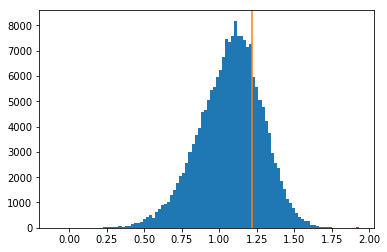

In [231]:
# Cell 20

# Histogram of first a value
plt.hist(samples[:, 0], 100);
plt.axvline(true_a[0], color="C1")

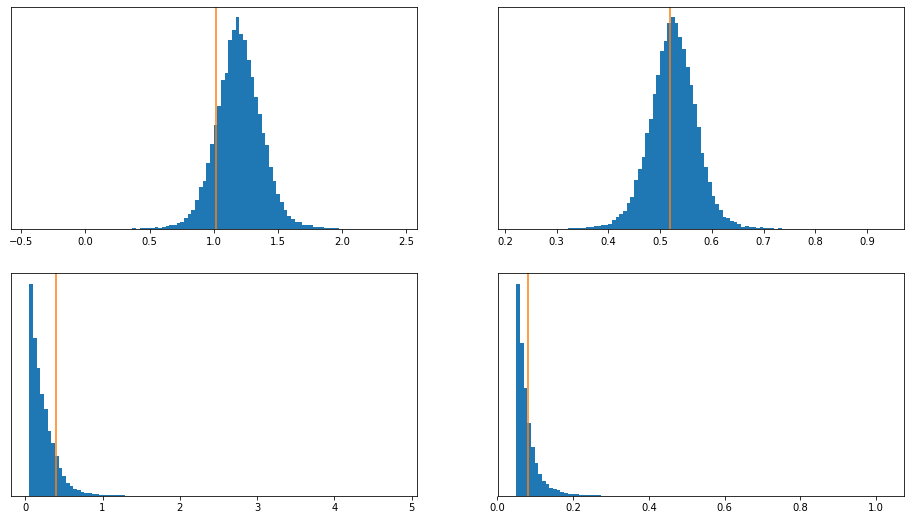

In [253]:
# Cell 21

fig = plt.figure(figsize=(16, 9))

# Histogram of first mu_a
ax = fig.add_subplot(221)
ax.hist(samples[:, M*2], 100);
ax.axvline(true_mu_a, color="C1")
ax.axes.get_yaxis().set_visible(False)

# Histogram of mu_b
ax = fig.add_subplot(222)
ax.hist(samples[:, M*2+1], 100);
plt.axvline(true_mu_b, color="C1")
ax.axes.get_yaxis().set_visible(False)

# Histogram of sigma_a
ax = fig.add_subplot(223)
ax.hist(np.exp(samples[:, M*2+2]), 100);
plt.axvline(true_sigma_a, color="C1")
ax.axes.get_yaxis().set_visible(False)

# Histogram of sigma_b
ax = fig.add_subplot(224)
ax.hist(np.exp(samples[:, M*2+3]), 100);
plt.axvline(true_sigma_b, color="C1")
ax.axes.get_yaxis().set_visible(False)

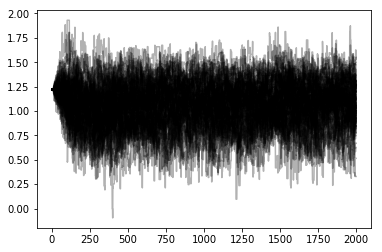

In [226]:
# Cell 22

plt.plot(sampler.chain[:, :, 0].T, "k", alpha=.3);

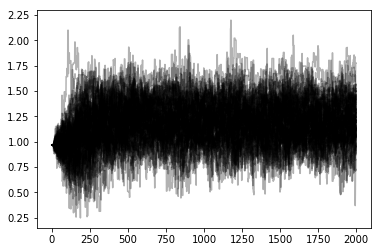

In [227]:
# Cell 23

plt.plot(sampler.chain[:, :, 1].T, "k", alpha=.3);

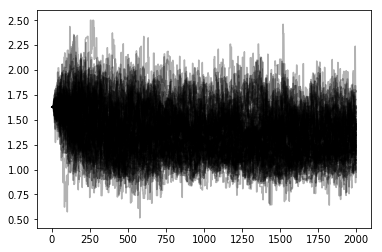

In [228]:
# Cell 24

plt.plot(sampler.chain[:, :, 3].T, "k", alpha=.3);

*Bonus exercise: How does PyMC3 scale as you add more parameters? How does emcee scale?*